<a href="https://colab.research.google.com/github/Anastasia3984/tennis_prediction/blob/main/tennis_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os
import sys
import glob
import re
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

In [8]:
folder = 'r.folder'

In [9]:
all_csvs = glob.glob(os.path.join(folder, "*.csv"))

In [10]:
dtypes = {
    "tourney_id": "category",
    "surface": "category",
    "winner_seed": "Int64",
}

In [11]:
df_list = []
for csv_file in all_csvs:
    df = pd.read_csv(
        csv_file,
        parse_dates=["tourney_date"],
        dtype=dtypes
    )
    df_list.append(df)

In [12]:
df = pd.concat(df_list, ignore_index=True)

In [13]:
df['tourney_date'] = pd.to_datetime(df['tourney_date'])

In [14]:
df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

In [15]:
df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2014-339,Brisbane,Hard,28,A,2013-12-29,1,103813,<NA>,NaN,...,29.0,23.0,6.0,8.0,2.0,5.0,39.0,1090.0,136.0,425.0
1,2014-339,Brisbane,Hard,28,A,2013-12-29,2,104594,<NA>,NaN,...,76.0,51.0,18.0,17.0,7.0,11.0,61.0,774.0,35.0,1160.0
2,2014-339,Brisbane,Hard,28,A,2013-12-29,3,105023,<NA>,NaN,...,40.0,26.0,12.0,11.0,6.0,9.0,46.0,960.0,29.0,1244.0
3,2014-339,Brisbane,Hard,28,A,2013-12-29,4,105032,<NA>,WC,...,59.0,43.0,15.0,12.0,4.0,4.0,172.0,307.0,100.0,549.0
4,2014-339,Brisbane,Hard,28,A,2013-12-29,5,103917,<NA>,NaN,...,50.0,43.0,12.0,14.0,2.0,4.0,50.0,918.0,70.0,697.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55233,2013-605,Tour Finals,Hard,8,F,2013-11-04,515,104925,2,NaN,...,45.0,26.0,8.0,9.0,8.0,11.0,2.0,10610.0,1.0,12030.0
55234,2013-D015,Davis Cup WG F: SRB vs CZE,Hard,4,D,2013-11-15,1,104925,<NA>,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,12110.0,44.0,970.0
55235,2013-D015,Davis Cup WG F: SRB vs CZE,Hard,4,D,2013-11-15,2,104607,<NA>,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,4180.0,117.0,483.0
55236,2013-D015,Davis Cup WG F: SRB vs CZE,Hard,4,D,2013-11-15,4,104925,<NA>,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,12110.0,7.0,4180.0


In [16]:
df.isnull().sum()

,0
tourney_id,0
tourney_name,0
surface,53
draw_size,0
tourney_level,0
tourney_date,0
match_num,0
winner_id,0
winner_seed,31720
winner_entry,48053


In [17]:
df = df.dropna(subset=['surface'])

In [18]:
counts = df['surface'].value_counts()
print(counts)

surface
Hard      31388
Clay      17448
Grass      5773
Carpet      576
Name: count, dtype: int64


In [19]:
surface_dummies = pd.get_dummies(df['surface'], prefix='surface')
df = pd.concat([df, surface_dummies], axis=1)
df.drop(columns=['surface'], inplace=True)

In [20]:
df

,tourney_id,tourney_name,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,...,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,surface_Carpet,surface_Clay,surface_Grass,surface_Hard
0,2014-339,Brisbane,28,A,2013-12-29,1,103813,<NA>,NaN,Jarkko Nieminen,...,2.0,5.0,39.0,1090.0,136.0,425.0,False,False,False,True
1,2014-339,Brisbane,28,A,2013-12-29,2,104594,<NA>,NaN,Marinko Matosevic,...,7.0,11.0,61.0,774.0,35.0,1160.0,False,False,False,True
2,2014-339,Brisbane,28,A,2013-12-29,3,105023,<NA>,NaN,Sam Querrey,...,6.0,9.0,46.0,960.0,29.0,1244.0,False,False,False,True
3,2014-339,Brisbane,28,A,2013-12-29,4,105032,<NA>,WC,Sam Groth,...,4.0,4.0,172.0,307.0,100.0,549.0,False,False,False,True
4,2014-339,Brisbane,28,A,2013-12-29,5,103917,<NA>,NaN,Nicolas Mahut,...,2.0,4.0,50.0,918.0,70.0,697.0,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55233,2013-605,Tour Finals,8,F,2013-11-04,515,104925,2,NaN,Novak Djokovic,...,8.0,11.0,2.0,10610.0,1.0,12030.0,False,False,False,True
55234,2013-D015,Davis Cup WG F: SRB vs CZE,4,D,2013-11-15,1,104925,<NA>,NaN,Novak Djokovic,...,NaN,NaN,2.0,12110.0,44.0,970.0,False,False,False,True
55235,2013-D015,Davis Cup WG F: SRB vs CZE,4,D,2013-11-15,2,104607,<NA>,NaN,Tomas Berdych,...,NaN,NaN,7.0,4180.0,117.0,483.0,False,False,False,True
55236,2013-D015,Davis Cup WG F: SRB vs CZE,4,D,2013-11-15,4,104925,<NA>,NaN,Novak Djokovic,...,NaN,NaN,2.0,12110.0,7.0,4180.0,False,False,False,True


In [21]:
df['winner_seed'] = df['winner_seed'].fillna(0).astype(int)
df['loser_seed']  = df['loser_seed'].fillna(0).astype(int)

In [22]:
df.isnull().sum()

,0
tourney_id,0
tourney_name,0
draw_size,0
tourney_level,0
tourney_date,0
match_num,0
winner_id,0
winner_seed,0
winner_entry,48000
winner_name,0


In [23]:
counts = df['winner_entry'].value_counts()
counts

,count
winner_entry,
Q,4015
WC,2239
LL,585
PR,238
SE,82
Alt,20
ALT,3
UP,1
ITF,1


In [24]:
freq = df['winner_entry'].value_counts(normalize=True)
common = freq[freq > 0.01].index.tolist()
df['winner_entry'] = df['winner_entry'].fillna('D').astype(str)
df['winner_entry'] = df['winner_entry'].where(df['winner_entry'].isin(common), other='OTHER')

freq = df['loser_entry'].value_counts(normalize=True)
common = freq[freq > 0.01].index.tolist()
df['loser_entry'] = df['loser_entry'].fillna('D').astype(str)
df['loser_entry'] = df['loser_entry'].where(df['loser_entry'].isin(common), other='OTHER')

In [25]:
counts = df['loser_entry'].value_counts()
counts

,count
loser_entry,
OTHER,43720
Q,6360
WC,3712
LL,1115
PR,278


In [26]:
entry_dummies = pd.get_dummies(
    df[['winner_entry','loser_entry']],
    prefix=['wi','lo']
)
df = pd.concat([df, entry_dummies], axis=1)
df.drop(columns=['winner_entry','loser_entry'], inplace=True)

In [27]:
df

,tourney_id,tourney_name,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_name,winner_hand,...,wi_OTHER,wi_PR,wi_Q,wi_SE,wi_WC,lo_LL,lo_OTHER,lo_PR,lo_Q,lo_WC
0,2014-339,Brisbane,28,A,2013-12-29,1,103813,0,Jarkko Nieminen,L,...,True,False,False,False,False,False,False,False,False,True
1,2014-339,Brisbane,28,A,2013-12-29,2,104594,0,Marinko Matosevic,R,...,True,False,False,False,False,False,True,False,False,False
2,2014-339,Brisbane,28,A,2013-12-29,3,105023,0,Sam Querrey,R,...,True,False,False,False,False,False,True,False,False,False
3,2014-339,Brisbane,28,A,2013-12-29,4,105032,0,Sam Groth,R,...,False,False,False,False,True,False,False,False,True,False
4,2014-339,Brisbane,28,A,2013-12-29,5,103917,0,Nicolas Mahut,R,...,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55233,2013-605,Tour Finals,8,F,2013-11-04,515,104925,2,Novak Djokovic,R,...,True,False,False,False,False,False,True,False,False,False
55234,2013-D015,Davis Cup WG F: SRB vs CZE,4,D,2013-11-15,1,104925,0,Novak Djokovic,R,...,True,False,False,False,False,False,True,False,False,False
55235,2013-D015,Davis Cup WG F: SRB vs CZE,4,D,2013-11-15,2,104607,0,Tomas Berdych,R,...,True,False,False,False,False,False,True,False,False,False
55236,2013-D015,Davis Cup WG F: SRB vs CZE,4,D,2013-11-15,4,104925,0,Novak Djokovic,R,...,True,False,False,False,False,False,True,False,False,False


In [28]:
c_nan = df.columns[df.isna().any()].tolist()
c_nan

['winner_ht',
 'winner_age',
 'loser_hand',
 'loser_ht',
 'loser_age',
 'minutes',
 'w_ace',
 'w_df',
 'w_svpt',
 'w_1stIn',
 'w_1stWon',
 'w_2ndWon',
 'w_SvGms',
 'w_bpSaved',
 'w_bpFaced',
 'l_ace',
 'l_df',
 'l_svpt',
 'l_1stIn',
 'l_1stWon',
 'l_2ndWon',
 'l_SvGms',
 'l_bpSaved',
 'l_bpFaced',
 'winner_rank',
 'winner_rank_points',
 'loser_rank',
 'loser_rank_points']

In [29]:
numeric_df = df.select_dtypes(include=[np.number])

In [30]:
print(df['minutes'])

0         72.0
1        161.0
2         77.0
3         95.0
4        107.0
         ...  
55233     96.0
55234      NaN
55235      NaN
55236      NaN
55237      NaN
Name: minutes, Length: 55185, dtype: float64


In [31]:
df.columns

Index(['tourney_id', 'tourney_name', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_name',
       'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'loser_id',
       'loser_seed', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc',
       'loser_age', 'score', 'best_of', 'round', 'minutes', 'w_ace', 'w_df',
       'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved',
       'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon',
       'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_rank',
       'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'surface_Carpet', 'surface_Clay', 'surface_Grass', 'surface_Hard',
       'wi_LL', 'wi_OTHER', 'wi_PR', 'wi_Q', 'wi_SE', 'wi_WC', 'lo_LL',
       'lo_OTHER', 'lo_PR', 'lo_Q', 'lo_WC'],
      dtype='object')

In [32]:
c_nan = df.columns[df.isna().any()].tolist()
c_nan

['winner_ht',
 'winner_age',
 'loser_hand',
 'loser_ht',
 'loser_age',
 'minutes',
 'w_ace',
 'w_df',
 'w_svpt',
 'w_1stIn',
 'w_1stWon',
 'w_2ndWon',
 'w_SvGms',
 'w_bpSaved',
 'w_bpFaced',
 'l_ace',
 'l_df',
 'l_svpt',
 'l_1stIn',
 'l_1stWon',
 'l_2ndWon',
 'l_SvGms',
 'l_bpSaved',
 'l_bpFaced',
 'winner_rank',
 'winner_rank_points',
 'loser_rank',
 'loser_rank_points']

In [33]:
prnt = df['w_ace'].isnull().sum()
prnt

np.int64(4150)

In [34]:
df = df.dropna(subset=[
    'w_ace', 'w_df', 'w_svpt', 'w_1stIn',
    'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced',
    'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms',
    'l_bpSaved', 'l_bpFaced'
])

In [35]:
c_nan = df.columns[df.isna().any()].tolist()
c_nan

['winner_ht',
 'winner_age',
 'loser_ht',
 'loser_age',
 'minutes',
 'winner_rank',
 'winner_rank_points',
 'loser_rank',
 'loser_rank_points']

In [36]:
prnt2 = df['loser_ht'].isnull().sum()
prnt2

np.int64(448)

In [37]:
prnt3 = df['winner_ht'].isnull().sum()
prnt3

np.int64(119)

In [38]:
df = df.copy()

median_m = df['minutes'].median()
median_w = df['winner_ht'].median()
median_l = df['loser_ht'].median()

df['minutes'] - df['minutes'].fillna(median_m)
df['winner_ht'] = df['winner_ht'].fillna(median_w)
df['loser_ht']  = df['loser_ht'].fillna(median_l)

print(median_m)
print(median_w)
print(median_l)

102.0
185.0
185.0


In [39]:
c_nan = df.columns[df.isna().any()].tolist()
c_nan

['winner_age',
 'loser_age',
 'minutes',
 'winner_rank',
 'winner_rank_points',
 'loser_rank',
 'loser_rank_points']

In [40]:
prnt4 = df['loser_age'].isnull().sum()
prnt4

np.int64(1)

In [41]:
df = df.dropna(subset=['winner_age', 'loser_age'])

In [42]:
prnt6 = df['loser_rank'].isnull().sum()
prnt6

np.int64(273)

In [43]:
median_wr = int(df['winner_rank'].median())
median_lr = int(df['loser_rank'].median())

df.loc[:, 'winner_rank'] = df['winner_rank'].fillna(median_wr).astype(int)
df.loc[:, 'loser_rank'] = df['loser_rank'].fillna(median_lr).astype(int)

df.loc[:, 'winner_rank_points'] = df['winner_rank_points'].fillna(0)
df.loc[:, 'loser_rank_points']  = df['loser_rank_points'].fillna(0)

print(median_wr)
print(median_lr)

42
65


In [44]:
c_nan = df.columns[df.isna().any()].tolist()
c_nan

['minutes']

In [45]:
prnt6 = df['minutes'].isnull().sum()
prnt6

np.int64(1709)

In [46]:
df = df.dropna(subset=['minutes'])

In [47]:
df.columns

Index(['tourney_id', 'tourney_name', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_name',
       'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'loser_id',
       'loser_seed', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc',
       'loser_age', 'score', 'best_of', 'round', 'minutes', 'w_ace', 'w_df',
       'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved',
       'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon',
       'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_rank',
       'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'surface_Carpet', 'surface_Clay', 'surface_Grass', 'surface_Hard',
       'wi_LL', 'wi_OTHER', 'wi_PR', 'wi_Q', 'wi_SE', 'wi_WC', 'lo_LL',
       'lo_OTHER', 'lo_PR', 'lo_Q', 'lo_WC'],
      dtype='object')

In [48]:
df = df.sort_values(['tourney_date', 'match_num']).reset_index(drop=True)

In [49]:
df

,tourney_id,tourney_name,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_name,winner_hand,...,wi_OTHER,wi_PR,wi_Q,wi_SE,wi_WC,lo_LL,lo_OTHER,lo_PR,lo_Q,lo_WC
0,2006-339,Adelaide,32,A,2006-01-02,1,103720,1,Lleyton Hewitt,R,...,True,False,False,False,False,False,True,False,False,False
1,2006-451,Doha,32,A,2006-01-02,1,103819,1,Roger Federer,R,...,True,False,False,False,False,False,False,False,False,True
2,2006-891,Chennai,32,A,2006-01-02,1,103344,1,Ivan Ljubicic,R,...,True,False,False,False,False,False,True,False,False,False
3,2006-339,Adelaide,32,A,2006-01-02,2,104259,0,Philipp Kohlschreiber,R,...,True,False,False,False,False,False,False,False,False,True
4,2006-451,Doha,32,A,2006-01-02,2,102148,0,Fabrice Santoro,R,...,True,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49318,2024-7696,Next Gen Finals,8,F,2024-12-18,396,210530,5,Learner Tien,L,...,True,False,False,False,False,False,True,False,False,False
49319,2024-7696,Next Gen Finals,8,F,2024-12-18,397,209950,1,Arthur Fils,R,...,True,False,False,False,False,False,True,False,False,False
49320,2024-7696,Next Gen Finals,8,F,2024-12-18,398,210530,5,Learner Tien,L,...,True,False,False,False,False,False,True,False,False,False
49321,2024-7696,Next Gen Finals,8,F,2024-12-18,399,211663,8,Joao Fonseca,R,...,True,False,False,False,False,False,True,False,False,False


In [50]:
df_pos = df.copy()
df_pos['target'] = 1

df_neg = df.copy()
df_neg['target'] = 0

In [51]:
cols_w = [c for c in df.columns if c.startswith('winner_')]
cols_l = [c for c in df.columns if c.startswith('loser_')]
rename_map = {}
for w, l in zip(cols_w, cols_l):
    suf = w.replace('winner_','')
    rename_map[w] = 'loser_' + suf
    rename_map[l] = 'winner_' + suf

In [52]:
df_neg = df_neg.rename(columns=rename_map)

In [53]:
df_full = pd.concat([df_pos, df_neg], ignore_index=True)

In [54]:
df_full['target']

,target
0,1
1,1
2,1
3,1
4,1
...,...
98641,0
98642,0
98643,0
98644,0


In [55]:
df_full['rank_diff'] = df_full['loser_rank'] - df_full['winner_rank']

In [56]:
df_full['rank_points_diff'] = (df_full['winner_rank_points'] - df_full['loser_rank_points'])

In [57]:
df_full['age_diff'] = df_full['winner_age'] - df_full['loser_age']

In [58]:
df_full['height_diff'] = df_full['winner_ht'] - df_full['loser_ht']

In [59]:
df_full['seed_diff'] = (df_full['winner_seed'].fillna(0) - df_full['loser_seed'].fillna(0))

In [60]:
df_full['surface_Hard']

,surface_Hard
0,True
1,True
2,True
3,True
4,True
...,...
98641,True
98642,True
98643,True
98644,True


In [61]:
df_full = df_full.sort_values('tourney_date').reset_index(drop=True)
df_full['match_index'] = df_full.index

surfaces = ['Carpet','Clay','Grass','Hard']
for s in surfaces:
    df_full[f'surface_{s}'] = df_full[f'surface_{s}'].astype(int)

df_full['surface'] = (
    df_full[[f'surface_{s}' for s in surfaces]]
      .idxmax(axis=1)
      .str.replace('surface_','')
)

In [62]:
w = df_full[['match_index','tourney_date','surface','winner_id']].rename(
    columns={'winner_id':'player_id'}).assign(won=1, role='winner')

l = df_full[['match_index','tourney_date','surface','loser_id']].rename(
    columns={'loser_id':'player_id'}).assign(won=0, role='loser')

df_long = pd.concat([w, l], ignore_index=True)
df_long = df_long.sort_values(['player_id','tourney_date']).reset_index(drop=True)


In [63]:
N = 10
df_long = df_long.sort_values(['player_id', 'tourney_date']).reset_index(drop=True)

df_long['winrate_lastN'] = (
    df_long
      .groupby('player_id')['won']
      .transform(lambda s: s.shift(1).rolling(window=N, min_periods=1).mean().fillna(0))
)

df_long['winrate_surf_lastN'] = (
    df_long
      .groupby(['player_id', 'surface'])['won']
      .transform(lambda s: s.shift(1).rolling(window=N, min_periods=1).mean().fillna(0))
)

In [64]:
stats = df_long[['match_index','role','winrate_lastN','winrate_surf_lastN']]

win_stats = stats[stats['role']=='winner'].rename(columns={
    'winrate_lastN':'winner_winrate_lastN',
    'winrate_surf_lastN':'winner_surf_winrate_lastN'
})[['match_index','winner_winrate_lastN','winner_surf_winrate_lastN']]

lose_stats = stats[stats['role']=='loser'].rename(columns={
    'winrate_lastN':'loser_winrate_lastN',
    'winrate_surf_lastN':'loser_surf_winrate_lastN'
})[['match_index','loser_winrate_lastN','loser_surf_winrate_lastN']]

df_full = df_full.merge(win_stats, on='match_index', how='left')
df_full = df_full.merge(lose_stats, on='match_index', how='left')


In [65]:
M = 3

tourn_agg = (
    df_long
      .groupby(['player_id', 'tourney_date'])
      .agg(wins=('won', 'sum'), matches=('won', 'count'))
      .reset_index()
)
tourn_agg['losses'] = tourn_agg['matches'] - tourn_agg['wins']
tourn_agg = tourn_agg.sort_values(['player_id', 'tourney_date']).reset_index(drop=True)
tourn_agg['wins_lastM_tourn'] = (
    tourn_agg.groupby('player_id')['wins'].transform(lambda s: s.shift(1).rolling(window=M, min_periods=1).sum().fillna(0))
)

tourn_agg['losses_lastM_tourn'] = (
    tourn_agg.groupby('player_id')['losses'].transform(lambda s: s.shift(1).rolling(window=M, min_periods=1).sum().fillna(0))
)

tourn_stats = tourn_agg[[
    'player_id',
    'tourney_date',
    'wins_lastM_tourn',
    'losses_lastM_tourn'
]]

In [66]:
df_full = df_full.merge(
    tourn_stats.rename(columns={
        'player_id':'winner_id',
        'tourney_date':'tourney_date',
        'wins_lastM_tourn':'winner_wins_lastM_tourn',
        'losses_lastM_tourn':'winner_losses_lastM_tourn'
    }),
    on=['winner_id','tourney_date'], how='left'
)
df_full = df_full.merge(
    tourn_stats.rename(columns={
        'player_id':'loser_id',
        'tourney_date':'tourney_date',
        'wins_lastM_tourn':'loser_wins_lastM_tourn',
        'losses_lastM_tourn':'loser_losses_lastM_tourn'
    }),
    on=['loser_id','tourney_date'], how='left'
)

In [67]:
c_nan = df_full.columns[df_full.isna().any()].tolist()
c_nan

[]

In [68]:
hand_map = {'R': 1, 'L': 0}

df_full['winner_hand'] = (df_full['winner_hand'].map(hand_map).fillna(-1).astype(int))
df_full['loser_hand'] = (df_full['loser_hand'].map(hand_map).fillna(-1).astype(int))

In [69]:
df_full.columns

Index(['tourney_id', 'tourney_name', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_name',
       'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'loser_id',
       'loser_seed', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc',
       'loser_age', 'score', 'best_of', 'round', 'minutes', 'w_ace', 'w_df',
       'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved',
       'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon',
       'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_rank',
       'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'surface_Carpet', 'surface_Clay', 'surface_Grass', 'surface_Hard',
       'wi_LL', 'wi_OTHER', 'wi_PR', 'wi_Q', 'wi_SE', 'wi_WC', 'lo_LL',
       'lo_OTHER', 'lo_PR', 'lo_Q', 'lo_WC', 'target', 'rank_diff',
       'rank_points_diff', 'age_diff', 'height_diff', 'seed_diff',
       'match_index', 'surface', 'winner_winrate_lastN',
       'w

In [70]:
pd.options.display.float_format = '{:.2f}'.format
corr_matrix = df_full.corr(numeric_only=True)
print(corr_matrix)

                           draw_size  match_num  winner_id  winner_seed  \
draw_size                       1.00       0.07      -0.00         0.31   
match_num                       0.07       1.00       0.29         0.03   
winner_id                      -0.00       0.29       1.00         0.00   
winner_seed                     0.31       0.03       0.00         1.00   
winner_hand                     0.01      -0.02      -0.02         0.03   
...                              ...        ...        ...          ...   
loser_surf_winrate_lastN       -0.04      -0.05       0.00         0.01   
winner_wins_lastM_tourn         0.12       0.04      -0.04         0.20   
winner_losses_lastM_tourn       0.12       0.04      -0.04         0.20   
loser_wins_lastM_tourn          0.12       0.04      -0.02         0.04   
loser_losses_lastM_tourn        0.12       0.04      -0.02         0.04   

                           winner_hand  winner_ht  winner_age  loser_id  \
draw_size               

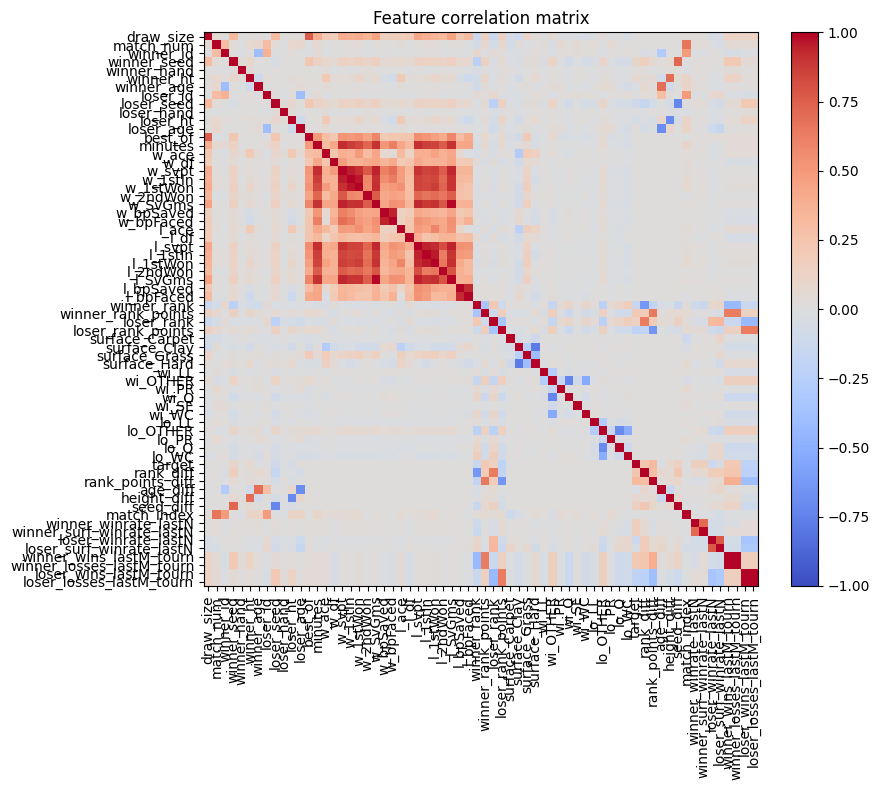

In [71]:
plt.figure(figsize=(10, 8))
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title("Feature correlation matrix")
plt.tight_layout()
plt.show()

In [72]:
corr_matrix = df_full.corr(numeric_only=True)
corr_matrix['target'].sort_values(key = lambda x: abs(x),ascending=False)

,target
target,1.00
rank_points_diff,0.32
rank_diff,0.22
winner_rank_points,0.21
loser_rank_points,-0.21
...,...
w_bpFaced,-0.00
l_bpFaced,0.00
wi_LL,0.00
w_bpSaved,-0.00


In [73]:
numeric_cols = df_full.select_dtypes(include=['number']).columns
corr_with_target = df_full[numeric_cols].corrwith(df_full['target'])
low_corr_cols = corr_with_target[ corr_with_target.abs() < 0.01 ].index.tolist()
low_corr_cols

['draw_size',
 'match_num',
 'winner_id',
 'loser_id',
 'best_of',
 'minutes',
 'w_ace',
 'w_df',
 'w_svpt',
 'w_1stIn',
 'w_1stWon',
 'w_2ndWon',
 'w_SvGms',
 'w_bpSaved',
 'w_bpFaced',
 'l_ace',
 'l_df',
 'l_svpt',
 'l_1stIn',
 'l_1stWon',
 'l_2ndWon',
 'l_SvGms',
 'l_bpSaved',
 'l_bpFaced',
 'surface_Carpet',
 'surface_Clay',
 'surface_Grass',
 'surface_Hard',
 'match_index']

In [74]:
df_full = df_full.drop(columns=['draw_size','match_num',
                                  'best_of','minutes','w_ace', 'w_df', 'w_svpt',
                                  'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',
                                  'w_bpSaved','w_bpFaced', 'l_ace', 'l_df',
                                  'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon',
                                  'l_SvGms', 'l_bpSaved', 'l_bpFaced',
                                  'surface_Carpet', 'surface_Clay', 'surface_Grass',
                                  'surface_Hard', 'match_index'])

In [75]:
corr_matrix = df_full.corr(numeric_only=True)
corr_matrix['target'].sort_values(key = lambda x: abs(x),ascending=False)

,target
target,1.00
rank_points_diff,0.32
rank_diff,0.22
winner_rank_points,0.21
loser_rank_points,-0.21
winner_losses_lastM_tourn,0.21
winner_wins_lastM_tourn,0.21
loser_wins_lastM_tourn,-0.21
loser_losses_lastM_tourn,-0.21
winner_surf_winrate_lastN,0.16


In [76]:
numeric_cols = df_full.select_dtypes(include=['number']).columns
corr_with_target = df_full[numeric_cols].corrwith(df_full['target'])
low_corr_cols = corr_with_target[ corr_with_target.abs() < 0.05].index.tolist()
low_corr_cols

['winner_id',
 'winner_hand',
 'winner_age',
 'loser_id',
 'loser_hand',
 'loser_age',
 'age_diff']

In [77]:
df_full = df_full.drop(columns=['winner_age', 'loser_age',
                                'winner_ht', 'loser_ht',
                                'winner_rank', 'loser_rank',
                                'winner_rank_points', 'loser_rank_points',
                                'winner_seed', 'loser_seed'
                                ])

In [78]:
df_full.columns

Index(['tourney_id', 'tourney_name', 'tourney_level', 'tourney_date',
       'winner_id', 'winner_name', 'winner_hand', 'winner_ioc', 'loser_id',
       'loser_name', 'loser_hand', 'loser_ioc', 'score', 'round', 'wi_LL',
       'wi_OTHER', 'wi_PR', 'wi_Q', 'wi_SE', 'wi_WC', 'lo_LL', 'lo_OTHER',
       'lo_PR', 'lo_Q', 'lo_WC', 'target', 'rank_diff', 'rank_points_diff',
       'age_diff', 'height_diff', 'seed_diff', 'surface',
       'winner_winrate_lastN', 'winner_surf_winrate_lastN',
       'loser_winrate_lastN', 'loser_surf_winrate_lastN',
       'winner_wins_lastM_tourn', 'winner_losses_lastM_tourn',
       'loser_wins_lastM_tourn', 'loser_losses_lastM_tourn'],
      dtype='object')

In [79]:
level_map = {'A':1,'D':2,'F':3,'G':4,'M':5,'O':6}
df_full['tourney_level_ord'] = df_full['tourney_level'].map(level_map)
df_full.drop(columns=['tourney_level'], inplace=True)

In [80]:
order = ['R128','R64','R32','R16','QF','SF','F']
round_map = { r: i for i, r in enumerate(order, 1) }
df_full['round_ord'] = df_full['round'].map(round_map).fillna(0).astype(int)
df_full.drop(columns=['round'], inplace=True)

In [81]:
df_h2h = df_full.sort_values('tourney_date').reset_index(drop=True)
df_h2h['h2h_wins']    = 0
df_h2h['h2h_losses'] = 0

h2h_counts = {}
for idx, row in df_h2h.iterrows():
    p_win = int(row['winner_id'])
    p_lose = int(row['loser_id'])
    if p_win < p_lose:
        key = (p_win, p_lose)
        idx_win_in_key   = 0
        idx_lose_in_key  = 1
    else:
        key = (p_lose, p_win)
        idx_win_in_key   = 1
        idx_lose_in_key  = 0
    if key not in h2h_counts:
        h2h_counts[key] = [0, 0]
    wins_key_0 = h2h_counts[key][0]
    wins_key_1 = h2h_counts[key][1]

    if p_win < p_lose:
        df_h2h.at[idx, 'h2h_wins']    = wins_key_0
        df_h2h.at[idx, 'h2h_losses']  = wins_key_1
        h2h_counts[key][0] += 1
    else:
        df_h2h.at[idx, 'h2h_wins']    = wins_key_1
        df_h2h.at[idx, 'h2h_losses']  = wins_key_0
        h2h_counts[key][1] += 1

df_h2h['h2h_total']    = df_h2h['h2h_wins'] + df_h2h['h2h_losses']
df_h2h['h2h_win_rate'] = df_h2h['h2h_wins'] / df_h2h['h2h_total'].replace(0, np.nan)
df_h2h['h2h_win_rate'] = df_h2h['h2h_win_rate'].fillna(0.5)
df_h2h['h2h_diff']     = df_h2h['h2h_wins'] - df_h2h['h2h_losses']
df_h2h['h2h_prev_met'] = (df_h2h['h2h_total'] > 0).astype(int)

df_full = df_h2h.copy()

In [82]:
df_full.columns

Index(['tourney_id', 'tourney_name', 'tourney_date', 'winner_id',
       'winner_name', 'winner_hand', 'winner_ioc', 'loser_id', 'loser_name',
       'loser_hand', 'loser_ioc', 'score', 'wi_LL', 'wi_OTHER', 'wi_PR',
       'wi_Q', 'wi_SE', 'wi_WC', 'lo_LL', 'lo_OTHER', 'lo_PR', 'lo_Q', 'lo_WC',
       'target', 'rank_diff', 'rank_points_diff', 'age_diff', 'height_diff',
       'seed_diff', 'surface', 'winner_winrate_lastN',
       'winner_surf_winrate_lastN', 'loser_winrate_lastN',
       'loser_surf_winrate_lastN', 'winner_wins_lastM_tourn',
       'winner_losses_lastM_tourn', 'loser_wins_lastM_tourn',
       'loser_losses_lastM_tourn', 'tourney_level_ord', 'round_ord',
       'h2h_wins', 'h2h_losses', 'h2h_total', 'h2h_win_rate', 'h2h_diff',
       'h2h_prev_met'],
      dtype='object')

In [83]:
df_full = df_full.drop(columns=['tourney_id', 'tourney_name', 'winner_id',
                                'winner_name', 'winner_hand', 'winner_ioc',
                                'loser_id', 'loser_name', 'loser_hand',
                                'loser_ioc', 'score', 'wi_LL', 'wi_OTHER',
                                'wi_PR', 'wi_Q', 'wi_SE', 'wi_WC', 'lo_LL',
                                'lo_OTHER', 'lo_PR', 'lo_Q', 'lo_WC'
                                ])

In [84]:
df_full = df_full.drop(columns=['winner_losses_lastM_tourn',
                                'loser_wins_lastM_tourn',
                                'h2h_wins', 'h2h_losses',
                                'h2h_prev_met'
                                ])

In [85]:
df_full.columns

Index(['tourney_date', 'target', 'rank_diff', 'rank_points_diff', 'age_diff',
       'height_diff', 'seed_diff', 'surface', 'winner_winrate_lastN',
       'winner_surf_winrate_lastN', 'loser_winrate_lastN',
       'loser_surf_winrate_lastN', 'winner_wins_lastM_tourn',
       'loser_losses_lastM_tourn', 'tourney_level_ord', 'round_ord',
       'h2h_total', 'h2h_win_rate', 'h2h_diff'],
      dtype='object')

In [86]:
df_pre2024 = df_full[df_full['tourney_date'].dt.year < 2024]

In [87]:
df_2024 = df_full[df_full['tourney_date'].dt.year == 2024]

In [88]:
train_df, val_df = train_test_split(
    df_pre2024,
    test_size=0.20,
    random_state=42,
    shuffle=True
)

In [89]:
test_df = df_2024.copy()

In [92]:
print(f"Train matches: {len(train_df)}")
print(f"Validation matches: {len(val_df)}")
print(f"Test matches (2024): {len(test_df)}")

Train matches: 74396
Validation matches: 18600
Test matches (2024): 5650


In [93]:
df_full.drop('tourney_date', axis = 1, inplace = True)

KeyError: "['tourney_date'] not found in axis"

In [94]:
train_df.columns

Index(['tourney_date', 'target', 'rank_diff', 'rank_points_diff', 'age_diff',
       'height_diff', 'seed_diff', 'surface', 'winner_winrate_lastN',
       'winner_surf_winrate_lastN', 'loser_winrate_lastN',
       'loser_surf_winrate_lastN', 'winner_wins_lastM_tourn',
       'loser_losses_lastM_tourn', 'tourney_level_ord', 'round_ord',
       'h2h_total', 'h2h_win_rate', 'h2h_diff'],
      dtype='object')

In [95]:
train_df = train_df.drop(columns=['tourney_date', 'loser_surf_winrate_lastN', 'winner_surf_winrate_lastN'])
val_df = val_df.drop(columns=['tourney_date', 'loser_surf_winrate_lastN', 'winner_surf_winrate_lastN'])
test_df = test_df.drop(columns=['tourney_date', 'loser_surf_winrate_lastN', 'winner_surf_winrate_lastN'])

In [96]:
train_df.isnull().sum()

,0
target,0
rank_diff,0
rank_points_diff,0
age_diff,0
height_diff,0
seed_diff,0
surface,0
winner_winrate_lastN,0
loser_winrate_lastN,0
winner_wins_lastM_tourn,0


In [97]:
def prepare(df):
    X = df.select_dtypes(include=[np.number]).drop(columns=['target'])
    y = df['target'].to_numpy()
    return X, y

train_X, train_y = prepare(train_df)
val_X, val_y   = prepare(val_df)
test_X, test_y = prepare(test_df)

In [98]:
from xgboost import XGBClassifier
pipe_rf = Pipeline([
    ('scale', StandardScaler()),
    ('rf', XGBClassifier(
        objective='binary:logistic',
        n_estimators=300,
        learning_rate=0.01,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.6,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        reg_lambda=5.0,
        reg_alpha=1.0
    ))
])

In [99]:
pipe_rf.fit(train_X, train_y)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:28:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('scale', StandardScaler()),
                ('rf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [100]:
xgb_model = pipe_rf.named_steps['rf']
importances = xgb_model.feature_importances_

feat_imp = pd.Series(data=importances, index=train_X.columns)
feat_imp_sorted = feat_imp.sort_values(ascending=False)

print("TOP 15 features by feature_importances_ (XGB):")
print(feat_imp_sorted.head(15).to_frame("importance"))


TOP 15 features by feature_importances_ (XGB):
                          importance
loser_winrate_lastN             0.23
rank_points_diff                0.20
winner_winrate_lastN            0.12
rank_diff                       0.10
loser_losses_lastM_tourn        0.07
round_ord                       0.06
winner_wins_lastM_tourn         0.05
h2h_diff                        0.04
h2h_win_rate                    0.04
seed_diff                       0.04
tourney_level_ord               0.03
h2h_total                       0.01
height_diff                     0.01
age_diff                        0.01


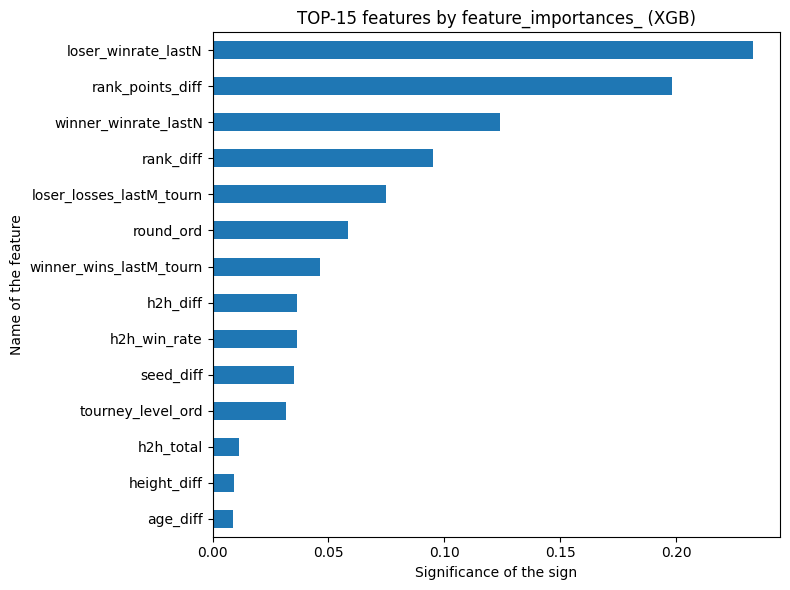

In [101]:
top_n = 15
top_features = feat_imp_sorted.head(top_n)

plt.figure(figsize=(8, 6))
top_features[::-1].plot(kind='barh')
plt.title(f"TOP-{top_n} features by feature_importances_ (XGB)")
plt.xlabel("Significance of the sign")
plt.ylabel("Name of the feature")
plt.tight_layout()
plt.show()


In [102]:
pipe_rf.fit(train_X, train_y)
val_pred  = pipe_rf.predict(val_X)
val_proba = pipe_rf.predict_proba(val_X)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:28:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [103]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

train_pred = pipe_rf.predict(train_X)
train_proba = pipe_rf.predict_proba(train_X)[:, 1]
train_acc  = accuracy_score(train_y, train_pred)
print("Train accuracy: ", train_acc)
print("Train ROC-AUC:   ", roc_auc_score(train_y, train_proba))

val_pred  = pipe_rf.predict(val_X)
val_proba = pipe_rf.predict_proba(val_X)[:, 1]
print("\nValidation accuracy: ", accuracy_score(val_y, val_pred))
print("Validation ROC-AUC:   ", roc_auc_score(val_y, val_proba))

test_pred  = pipe_rf.predict(test_X)
test_proba = pipe_rf.predict_proba(test_X)[:, 1]
print("\nTest accuracy: ", accuracy_score(test_y, test_pred))
print("Test ROC-AUC:   ", roc_auc_score(test_y, test_proba))

print("\nClassification report (VALIDATION):")
print(classification_report(val_y, val_pred))
print("Confusion matrix (VALIDATION):")
print(confusion_matrix(val_y, val_pred))

print("\nClassification report (TEST):")
print(classification_report(test_y, test_pred))
print("Confusion matrix (TEST):")
print(confusion_matrix(test_y, test_pred))

Train accuracy:  0.7509005860530136
Train ROC-AUC:    0.8397205144328617

Validation accuracy:  0.7434408602150537
Validation ROC-AUC:    0.8288320234519653

Test accuracy:  0.7307964601769912
Test ROC-AUC:    0.8150517033440363

Classification report (VALIDATION):
              precision    recall  f1-score   support

           0       0.75      0.72      0.74      9319
           1       0.73      0.76      0.75      9281

    accuracy                           0.74     18600
   macro avg       0.74      0.74      0.74     18600
weighted avg       0.74      0.74      0.74     18600

Confusion matrix (VALIDATION):
[[6753 2566]
 [2206 7075]]

Classification report (TEST):
              precision    recall  f1-score   support

           0       0.74      0.71      0.73      2825
           1       0.72      0.75      0.74      2825

    accuracy                           0.73      5650
   macro avg       0.73      0.73      0.73      5650
weighted avg       0.73      0.73      0.73   

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [2, 3, 4, 6],
    'rf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'rf__subsample': [0.4, 0.6, 0.8, 1.0],
    'rf__colsample_bytree': [0.4, 0.6, 0.8, 1.0],
}

grid_search = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(train_X, train_y)
print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
